##**Kasus 4: Dilema Strategis di Industri Pertambangan Indonesia**

PT Nusantara Mineral Sejahtera (NMS) adalah perusahaan pertambangan terkemuka di Indonesia yang telah beroperasi sejak tahun 2000. Perusahaan ini bergerak dalam bidang ekstraksi dan pengolahan mineral dengan konsesi di empat lokasi tambang aktif di Kalimantan Timur. Perusahaan saat ini menghadapi situasi yang kompleks akibat perubahan regulasi pemerintah, fluktuasi pasar global, dan tantangan operasional internal. Hal ini memerlukan perencanaan strategi operasional yang cermat untuk lima tahun ke depan.


Tantangan utama yang dihadapi meliputi:

1. Optimalisasi Operasi Tambang
- Setiap tambang memiliki kapasitas produksi maksimum per tahun yang berbeda: Tambang 1 (2 juta ton), Tambang 2 (2,5 juta ton), Tambang 3 (1,3 juta ton), dan Tambang 4 (3 juta ton).
- Terdapat rekomendasi untuk mengoperasikan maksimal tiga dari empat tambang yang tersedia dalam satu tahun.

2. Manajemen Kualitas Bijih:
- Setiap tambang memiliki kualitas bijih yang berbeda, diukur dalam skala tertentu: Tambang 1 (1,0), Tambang 2 (0,7), Tambang 3 (1,5), dan Tambang 4 (0,5).
- Kebutuhan kualitas campuran bijih yang harus dipenuhi bervariasi setiap tahunnya: Tahun 1 (0,9), Tahun 2 (0,8), Tahun 3 (1,2), Tahun 4 (0,6), dan Tahun 5 (1,0).

3. Aspek Finansial:
- Setiap tambang dikenakan biaya royalti tahunan: Tambang 1 (Rp 75 miliar), Tambang 2 (Rp 60 miliar), Tambang 3 (Rp 60 miliar), dan Tambang 4 (Rp 75 miliar).
- Perusahaan dapat mempertahankan konsesi suatu tambang pada tahun tertentu (dengan tetap membayar royalti) walau tidak mengoperasikannya pada tahun tersebut, sehingga tetap dapat mengoperasikan tambang tersebut pada tahun berikutnya.
- Harga jual untuk bijih campuran yang dihasilkan adalah Rp 150.000 per ton.
- Analisis finansial harus mempertimbangkan tingkat diskonto sebesar 10% per tahun.

Perusahaan perlu menentukan kombinasi operasi tambang dan alokasi produksi yang optimal setiap tahunnya untuk memenuhi target kualitas campuran, mematuhi batasan operasi, dan memaksimalkan nilai finansial selama lima tahun ke depan.

##**Penyelesaian**

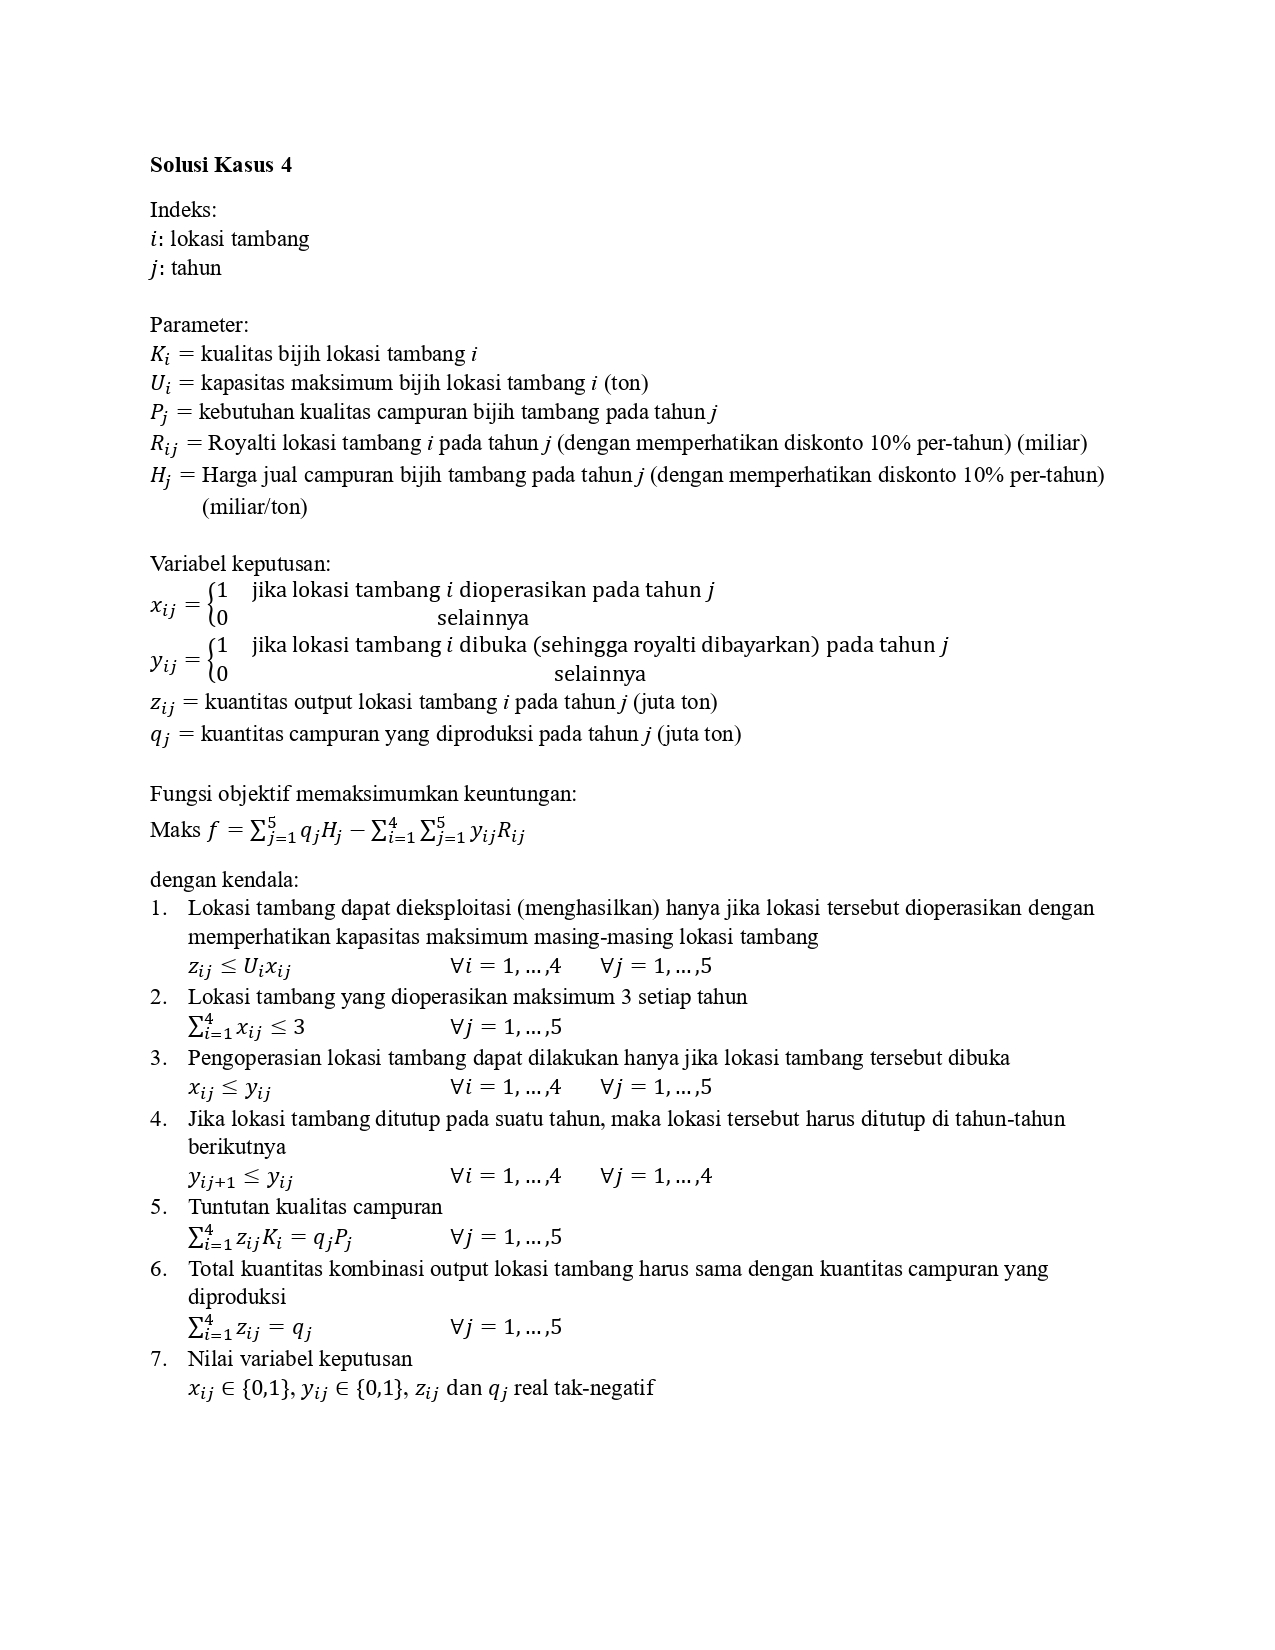

##**Implementasi Pyomo**

Pyomo adalah alat bantu dalam Riset Operasi yang menggunakan Python untuk membuat dan menyelesaikan model matematika guna mengoptimalkan solusi dari berbagai masalah optimasi (maksimisasi dan minimisasi).

In [2]:
!pip install pyomo
!apt-get install -y -qq glpk-utils

In [3]:
from pyomo.environ import *

In [34]:
# Model
model = ConcreteModel()

# Indeks
model.I = RangeSet(1,4)
model.J = RangeSet(1,5)

# Kapasitas maksimum setiap tambang (juta ton)
kapasitas = [2.0, 2.5, 1.3, 3.0]
model.U = Param(model.I, initialize=lambda model, i: kapasitas[i-1])

# Kualitas bijih setiap tambang
kualitas = [1.0, 0.7, 1.5, 0.5]
model.K = Param(model.I, initialize=lambda model, i: kualitas[i-1])

# Kebutuhan kualitas campuran per tahun
kebutuhan_kualitas = [0.9, 0.8, 1.2, 0.6, 1.0]
model.P = Param(model.J, initialize=lambda model, j: kebutuhan_kualitas[j-1])

# Biaya royalti dasar per tambang (Rp miliar)
royalti_dasar = [75, 60, 60, 75]
model.R_base = Param(model.I, initialize=lambda model, i: royalti_dasar[i-1])

# Harga jual per ton (Rp miliar/ juta ton)
harga_jual = 150

# Tingkat diskonto
discount_rate = 0.10

# Faktor diskonto untuk setiap tahun
faktor_diskonto = [1/(1+discount_rate)**(j) for j in range(0,5)]
model.discount_factor = Param(model.J, initialize=lambda model, j: faktor_diskonto[j-1])

# Royalti yang telah didiskonto (Rp miliar)
def royalti_diskonto_init(model, i, j):
    return model.R_base[i] * model.discount_factor[j]
model.R = Param(model.I, model.J, initialize=royalti_diskonto_init)

# Harga jual yang telah didiskonto per juta ton (Rp miliar)
def harga_diskonto_init(model, j):
    return harga_jual * model.discount_factor[j]
model.H = Param(model.J, initialize=harga_diskonto_init)

# Variabel keputusan
model.x = Var(model.I, model.J, within=Binary)
model.y = Var(model.I, model.J, within=Binary)
model.z = Var(model.I, model.J, within=NonNegativeReals)
model.q = Var(model.J, within=NonNegativeReals)

# Objektif: Memaksimumkan keuntungan
def obj_func(model):
    revenue = sum(model.q[j] * model.H[j] for j in model.J)
    cost = sum(model.y[i,j] * model.R[i,j] for i in model.I for j in model.J)
    return revenue - cost
model.objective = Objective(rule=obj_func, sense=maximize)

# Kendala 1: Output tidak melebihi kapasitas jika tambang dioperasikan
def rule_const1(model, i, j):
    return model.z[i,j] <= model.U[i] * model.x[i,j]
model.const1 = Constraint(model.I, model.J, rule=rule_const1)

# Kendala 2: Maksimal 3 tambang yang dioperasikan per tahun
def rule_const2(model, j):
    return sum(model.x[i,j] for i in model.I) <= 3
model.const2 = Constraint(model.J, rule=rule_const2)

# Kendala 3: Tambang hanya bisa dioperasikan jika dibuka
def rule_const3(model, i, j):
    return model.x[i,j] <= model.y[i,j]
model.const3 = Constraint(model.I, model.J, rule=rule_const3)

# Kendala 4: Jika tambang ditutup, tidak bisa dibuka lagi di tahun berikutnya
def rule_const4(model, i, j):
    if j < 5:
        return model.y[i,j+1] <= model.y[i,j]
    else:
        return Constraint.Skip
model.const4 = Constraint(model.I, model.J, rule=rule_const4)

# Kendala 5: Memenuhi tuntutan kualitas campuran
def rule_const5(model, j):
    return sum(model.z[i,j] * model.K[i] for i in model.I) == model.q[j] * model.P[j]
model.const5 = Constraint(model.J, rule=rule_const5)

# Kendala 6: Total output sama dengan kuantitas campuran
def rule_const6(model, j):
    return sum(model.z[i,j] for i in model.I) == model.q[j]
model.const6 = Constraint(model.J, rule=rule_const6)

# Penyelesaian - menggunakan solver GLPK
result = SolverFactory('glpk').solve(model)

# Display output
print(f'Status solusi: {result.solver.termination_condition}')
print('Nilai fungsi objektif: Rp', model.objective(), "miliar\n")

# Menampilkan hasil per tahun
for j in model.J:
    print(f'=== TAHUN {j} ===')
    print(f'Q{j}: {model.q[j]():.2f} juta ton')
    print(f'Pendapatan: Rp {model.q[j]() * model.H[j]:.2f} miliar')
    print(f'Biaya Royalti: Rp {sum(model.y[i,j]() * model.R[i,j] for i in model.I):.2f} miliar')

    for i in model.I:
        if model.x[i,j]() > 0.5:
            status_royalti = 'Ya' if model.y[i,j]() > 0.5 else 'Tidak'
            print(f'Tambang {i}: Output={model.z[i,j]():.2f} juta ton, Royalti={status_royalti}')
    print()

# Menampilkan rencana pembayaran royalti
print('=== RENCANA PEMBAYARAN ROYALTI ===')
for i in model.I:
    tahun_buka = [j for j in model.J if model.y[i,j]() > 0.5]
    if tahun_buka:
        total_royalti = sum(model.y[i,j]() * model.R[i,j] for j in model.J)
        print(f'Tambang {i}: Dibuka tahun {(tahun_buka)}, Total Royalti: Rp {total_royalti:.2f} miliar')

Status solusi: optimal
Nilai fungsi objektif: Rp 2202.929615463425 miliar

=== TAHUN 1 ===
Q1: 5.75 juta ton
Pendapatan: Rp 862.50 miliar
Biaya Royalti: Rp 270.00 miliar
Tambang 1: Output=2.00 juta ton, Royalti=Ya
Tambang 3: Output=1.30 juta ton, Royalti=Ya
Tambang 4: Output=2.45 juta ton, Royalti=Ya

=== TAHUN 2 ===
Q2: 6.00 juta ton
Pendapatan: Rp 818.18 miliar
Biaya Royalti: Rp 245.45 miliar
Tambang 2: Output=2.50 juta ton, Royalti=Ya
Tambang 3: Output=1.30 juta ton, Royalti=Ya
Tambang 4: Output=2.20 juta ton, Royalti=Ya

=== TAHUN 3 ===
Q3: 3.25 juta ton
Pendapatan: Rp 402.89 miliar
Biaya Royalti: Rp 223.14 miliar
Tambang 1: Output=1.95 juta ton, Royalti=Ya
Tambang 3: Output=1.30 juta ton, Royalti=Ya

=== TAHUN 4 ===
Q4: 5.62 juta ton
Pendapatan: Rp 633.92 miliar
Biaya Royalti: Rp 202.85 miliar
Tambang 1: Output=0.12 juta ton, Royalti=Ya
Tambang 2: Output=2.50 juta ton, Royalti=Ya
Tambang 4: Output=3.00 juta ton, Royalti=Ya

=== TAHUN 5 ===
Q5: 5.47 juta ton
Pendapatan: Rp 560.07 m



---

Berdasarkan hasil solusi optimal model optimasi penambangan, perusahaan dapat mencapai total keuntungan sebesar **Rp 2.202,93 miliar** selama periode lima tahun dengan strategi operasi yang terencana. Solusi ini telah mempertimbangkan seluruh kendala operasional, termasuk kapasitas tambang, kebutuhan kualitas campuran, batasan jumlah tambang yang beroperasi, dan penerapan nilai waktu uang melalui tingkat diskonto 10%.



**Strategi Operasional Tambang**\
Perusahaan menerapkan strategi pembayaran royalti yang cerdas untuk menjaga fleksibilitas operasi:
- Tambang 1, 2, dan 3 membayar royalti secara konsisten selama 5 tahun penuh untuk mempertahankan hak operasi
- Tambang 4 membayar royalti selama 4 tahun pertama untuk kebutuhan kualitas spesifik
- Operasi produksi diprioritaskan pada tambang dengan ekonomi terbaik setiap tahunnya

**Alokasi Produksi yang Dinamis**\
Kombinasi tambang yang beroperasi dirotasi secara optimal setiap tahun:
- Tahun 1: Tambang 1, 3, 4 beroperasi dengan output 5,75 juta ton (maksimal)
- Tahun 2: Tambang 2, 3, 4 beroperasi mencapai puncak produksi 6,00 juta ton
- Tahun 3: Penyesuaian pasar dengan hanya Tambang 1 dan 3 yang beroperasi (3,25 juta ton)
- Tahun 4: Pemulihan produksi dengan Tambang 1, 2, 4 (5,62 juta ton)
- Tahun 5: Kombinasi optimal Tambang 1, 2, 3 (5,47 juta ton)

**Manajemen Keuangan yang Optimal**\
Penerapan nilai waktu uang memberikan keuntungan finansial signifikan:
- Biaya royalti turun progresif dari Rp 270 miliar (Tahun 1) menjadi Rp 133 miliar (Tahun 5) berkat dampak diskonto
- Total biaya royalti bernilai sekarang sebesar Rp 1.074,63 miliar, lebih rendah dari nilai nominalnya
- Profit margin mencapai 67,2% yang menunjukkan efisiensi operasional yang tinggi

**Kepatuhan terhadap Spesifikasi Kualitas**\
Model berhasil memenuhi semua requirement kualitas campuran setiap tahunnya melalui penyesuaian kombinasi tambang yang beroperasi, menjamin kepuasan pelanggan dan keberlanjutan bisnis.